# Phase 4 Project: Time Series Modeling

##  Forecasting Real Estate Prices Using Time Series

* Student Name: Andrea Cabello

## I. Overview 

I have been hired by a real-estate investment firm to help them understand:
- How real estate prices have changed overtime and, 
- How to use this information to invest in areas with the most potential value increase.

To get me started I have been provided with a dataset from [Zillow Research](https://www.zillow.com/research/data/)

### Home values

Zillow Home Value Index (ZHVI): A smoothed, seasonally adjusted measure of the typical home value and market changes across a given region and housing type. It reflects the typical value for homes in the 35th to 65th percentile range. 

### Housing Bubble

* On December 30, 2008, the [Case–Shiller home price index](https://en.wikipedia.org/wiki/Case%E2%80%93Shiller_index) reported its largest price drop in its history. 
* The credit crisis resulting from the bursting of the housing bubble is an important cause of the Great Recession in the United States.


## II. Business Problem

* What are the top 5 best zip codes for us to invest in?

Let's begin by defining best: 
* What makes the value of a property go up?
* Law of Supply and Demand. e movements. Property values rise when a low supply of homes for sale meets strong buyer demand, as buyers compete in bidding wars to secure a home from the limited inventory.

* Return On Investment
* Average price over time
* Jobs Market
* Population growth
* Access to the city center or other relevant landmarks

## III. Cleaning and Obtaining Data

In [61]:
import pandas as pd
from pandas import Series
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('zillow_data.csv')

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
print('Total Zipcodes in DataFrame:', len(df))

Total Zipcodes in DataFrame: 14723


### Connecticut

* The firm is particularly interested in off-the-beaten-path areas of the North East Coast so I will focus my analysis on CT zipcodes.

In [5]:
## selecting ct zipcodes
df_ct = df.loc[df['State']== 'CT'].reset_index()
df_ct.drop(['index', 'RegionID', 'City', 'State', 'CountyName'], axis=1, inplace=True)
df_ct.rename(columns={'RegionName': 'Zipcode'}, inplace=True)

In [6]:
df_ct.Metro.unique()

array(['Hartford', 'New Haven', 'Stamford', 'New London', 'Torrington',
       'Worcester'], dtype=object)

In [7]:
print(f'Number of CT zipcodes: {len(df_ct)}')

Number of CT zipcodes: 124


### Obtaining ROIs

In [8]:
## 5 year ROI
df_ct['ROI_5yr'] = round((df_ct['2018-04'] - df_ct['2013-01'])/ df_ct['2013-01'],4)
## 3 year ROI
df_ct['ROI_3yr'] = round((df_ct['2018-04'] - df_ct['2015-01'])/ df_ct['2013-01'],4)

In [9]:
df_ct.info()
df_ct.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Columns: 270 entries, Zipcode to ROI_3yr
dtypes: float64(221), int64(48), object(1)
memory usage: 261.7+ KB


,Zipcode,Metro,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI_5yr,ROI_3yr
0,6010,Hartford,113,120300.0,120000.0,119800.0,119400.0,119100.0,118800.0,118600.0,...,191200,191800,192900,193600,194100,194900,195700,195700,0.1063,0.0989
1,6516,New Haven,417,96500.0,96300.0,96100.0,95900.0,95600.0,95300.0,95000.0,...,177300,177800,178200,178700,179700,180200,179700,178700,0.0752,0.0951
2,6511,New Haven,546,89800.0,90000.0,90200.0,90300.0,90500.0,90700.0,90800.0,...,187700,190100,193100,196300,198400,199100,199100,198300,0.1462,0.1780
3,6810,Stamford,685,151100.0,150700.0,150200.0,149700.0,149100.0,148600.0,148200.0,...,258500,260900,262500,264000,265300,266100,266500,266500,0.2219,0.1898
4,6492,New Haven,899,146800.0,146600.0,146300.0,146100.0,145900.0,145700.0,145600.0,...,250200,251700,253100,254500,256100,257600,257600,256400,0.1182,0.0440


### Reshape from Wide to Long Format

In [10]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['Zipcode', 'Metro', 'SizeRank', 'ROI_5yr', 'ROI_3yr'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [11]:
melted_df = melt_data(df_ct)

In [12]:
melted_df.isna().value_counts()

Zipcode  Metro  SizeRank  ROI_5yr  ROI_3yr  Date   value
False    False  False     False    False    False  False    32860
dtype: int64

In [13]:
#Change Zipcode dtype to 'str'
melted_df['Zipcode'] = melted_df['Zipcode'].astype(str)

# Make sure the data type of the 'Date' column is datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'], format='%m/%y')

# Set the 'Date' column as index
melted_df.set_index('Date', inplace=True)

In [14]:
melted_df.index

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Date', length=32860, freq=None)

* The data includes home values by month since April 1996 to April 2018. 
* Given the 2008 Housing Bubble precedent, I have decided to slice the dates and start my analysis at January 2008. This leaves us with a 10 year time window. 

In [15]:
melted_df = melted_df['2008-01-01':'2018-04-01']

In [16]:
melted_df.info()
melted_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15376 entries, 2008-01-01 to 2018-04-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Zipcode   15376 non-null  object 
 1   Metro     15376 non-null  object 
 2   SizeRank  15376 non-null  int64  
 3   ROI_5yr   15376 non-null  float64
 4   ROI_3yr   15376 non-null  float64
 5   value     15376 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 840.9+ KB


,Zipcode,Metro,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,
2008-01-01,6010,Hartford,113,0.1063,0.0989,219300.0
2008-01-01,6516,New Haven,417,0.0752,0.0951,223900.0
2008-01-01,6511,New Haven,546,0.1462,0.1780,243500.0
2008-01-01,6810,Stamford,685,0.2219,0.1898,321900.0
2008-01-01,6492,New Haven,899,0.1182,0.0440,280200.0


In [17]:
melted_df.tail()

,Zipcode,Metro,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,
2018-04-01,6794,Torrington,14096,0.0378,0.0445,510500.0
2018-04-01,6793,Torrington,14356,0.2023,0.1683,664400.0
2018-04-01,6027,Hartford,14477,0.1301,0.0689,252700.0
2018-04-01,6796,Torrington,14552,0.1274,0.1901,418700.0
2018-04-01,6090,Hartford,14655,0.0770,0.0483,348200.0


### IV. EDA

* ### Metro

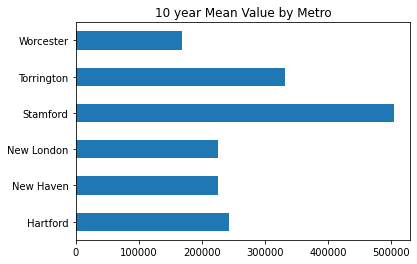

In [18]:
metro_grp = melted_df.groupby('Metro').value.mean()
metro_grp.plot.barh()
plt.title('10 year Mean Value by Metro')
plt.ylabel('')
plt.show()

Let's take a closer look into the top 3 with the highest mean value.

 * #### Stamford

In [19]:
stamford = melted_df.loc[melted_df['Metro']=='Stamford']
stamford.describe()

,SizeRank,ROI_5yr,ROI_3yr,value
count,1984.000000,1984.000000,1984.000000,1.984000e+03
mean,5395.500000,0.117881,0.069831,5.050442e+05
std,2786.125208,0.108130,0.123098,3.820920e+05
min,685.000000,-0.019200,-0.082700,1.185000e+05
25%,3724.750000,0.040875,-0.000075,2.750750e+05
50%,5896.500000,0.090450,0.032200,3.450000e+05
75%,6677.500000,0.155375,0.113975,7.189750e+05
max,11245.000000,0.320200,0.316000,1.746000e+06


 * #### Torrington

In [20]:
torrington = melted_df.loc[melted_df['Metro']=='Torrington']
torrington.describe()

,SizeRank,ROI_5yr,ROI_3yr,value
count,2480.000000,2480.000000,2480.000000,2480.000000
mean,11759.300000,0.150080,0.116480,331128.870968
std,2795.020029,0.099232,0.070266,123206.641312
min,3789.000000,0.015000,0.022500,135800.000000
25%,10302.250000,0.077700,0.060250,245900.000000
50%,13041.500000,0.146900,0.096700,307450.000000
75%,13663.000000,0.190975,0.173750,409825.000000
max,14552.000000,0.415800,0.244200,737800.000000


 * #### Hartford

In [21]:
hartford = melted_df.loc[melted_df['Metro']=='Hartford']
hartford.describe()

,SizeRank,ROI_5yr,ROI_3yr,value
count,4340.000000,4340.000000,4340.000000,4340.000000
mean,7921.885714,0.059234,0.069386,242469.493088
std,3897.308858,0.046046,0.038305,65698.245634
min,113.000000,-0.081200,-0.039200,103300.000000
25%,4011.000000,0.033900,0.038800,197475.000000
50%,8085.000000,0.063500,0.065500,242400.000000
75%,10809.000000,0.084400,0.094000,277900.000000
max,14655.000000,0.155800,0.141000,460500.000000


* ### SizeRank

As per SizeRank values seen below, our data includes very densely populated, somewhat populated, and also some of the least populated zipcodes in the US.

In [55]:
melted_df.SizeRank.unique()

array([  113,   417,   546,   685,   899,  1145,  1332,  1362,  1599,
        1901,  2093,  2192,  2301,  2390,  2497,  3051,  3245,  3281,
        3368,  3532,  3565,  3581,  3696,  3760,  3778,  3789,  3978,
        4011,  4230,  4324,  4531,  4587,  4674,  4717,  5580,  5624,
        5687,  5756,  5852,  5870,  5941,  6037,  6063,  6084,  6176,
        6270,  6288,  6329,  6424,  6591,  6599,  6813,  6913,  7022,
        7031,  7144,  7259,  7317,  7382,  7471,  7496,  7595,  7704,
        7741,  7890,  8085,  8368,  8425,  8427,  8584,  8601,  8943,
        9032,  9136,  9160,  9275,  9298,  9457,  9577,  9681,  9715,
        9788,  9871,  9903,  9977, 10164, 10281, 10446, 10463, 10591,
       10651, 10663, 10786, 10809, 10893, 11245, 11629, 11907, 11929,
       12034, 12184, 12310, 12406, 12469, 12556, 12817, 12967, 13018,
       13065, 13214, 13215, 13266, 13465, 13564, 13567, 13646, 13714,
       13908, 13927, 14096, 14356, 14477, 14552, 14655])

* ### Value

In [22]:
print('10 year average CT home value' ,round(melted_df['value'].mean(), 2))

10 year average CT home value 280233.14


In [23]:
melted_df['value'].describe()

count    1.537600e+04
mean     2.802331e+05
std      1.840456e+05
min      8.010000e+04
25%      1.838000e+05
50%      2.419000e+05
75%      3.145250e+05
max      1.746000e+06
Name: value, dtype: float64

<AxesSubplot:xlabel='Date'>

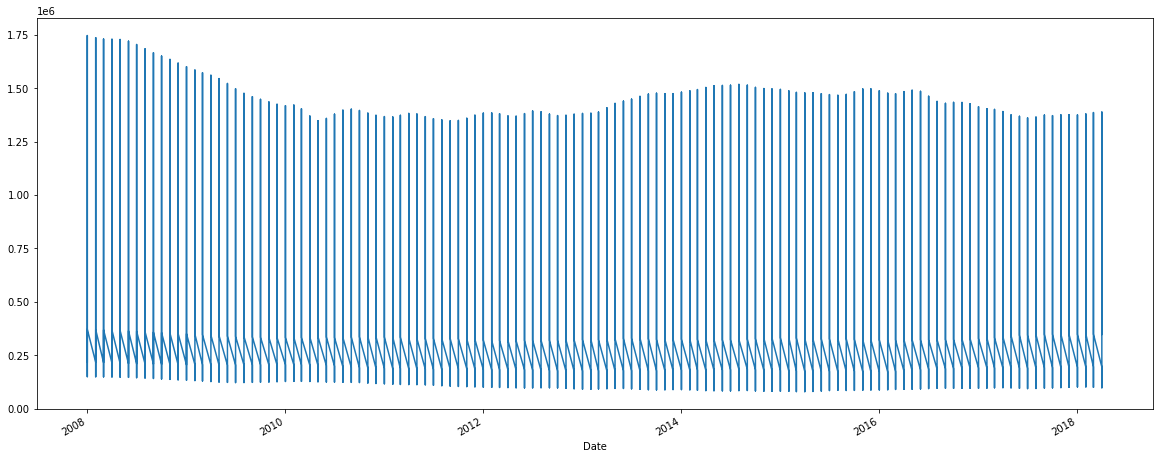

In [24]:
melted_df['value'].plot(figsize=(20,8))

My first plot isn't telling me much so I will resample by year to obtain a better visualization. 

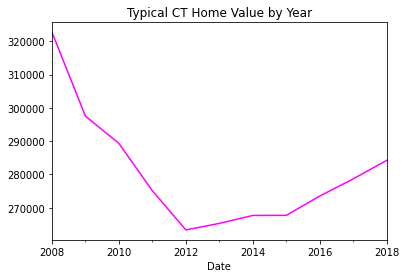

In [25]:
title = 'Typical CT Home Value by Year'
yearly_data = melted_df['value'].resample(rule='A').mean()
yearly_data.plot.line(title=title, color='magenta')
plt.show()

* ### Zipcode

In [58]:
zipcode_grp = melted_df.groupby('Zipcode')

Up next, we'll plot our Top 10 Zipcodes with the highest mean value between 2008 and 2018.

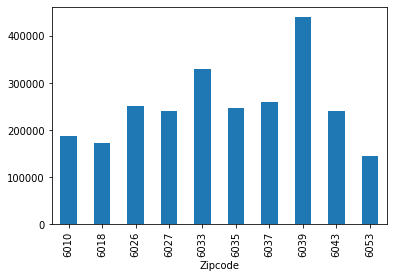

In [27]:
mean_value = zipcode_grp.value.mean()
mean_value = mean_value[:10]
mean_value.plot.bar()
plt.show()

Let's find our zipcode with the highest mean value.

In [28]:
melted_df.loc[melted_df['Zipcode']=='6039']

,Zipcode,Metro,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,
2008-01-01,6039,Torrington,13065,0.3212,0.2073,535900.0
2008-02-01,6039,Torrington,13065,0.3212,0.2073,537700.0
2008-03-01,6039,Torrington,13065,0.3212,0.2073,538100.0
2008-04-01,6039,Torrington,13065,0.3212,0.2073,538300.0
2008-05-01,6039,Torrington,13065,0.3212,0.2073,536700.0
...,...,...,...,...,...,...
2017-12-01,6039,Torrington,13065,0.3212,0.2073,468200.0
2018-01-01,6039,Torrington,13065,0.3212,0.2073,471500.0
2018-02-01,6039,Torrington,13065,0.3212,0.2073,473700.0


Second highest mean value:

In [29]:
melted_df.loc[melted_df['Zipcode']=='6033']

,Zipcode,Metro,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,
2008-01-01,6033,Hartford,3245,0.0514,0.0554,354500.0
2008-02-01,6033,Hartford,3245,0.0514,0.0554,353400.0
2008-03-01,6033,Hartford,3245,0.0514,0.0554,352700.0
2008-04-01,6033,Hartford,3245,0.0514,0.0554,352700.0
2008-05-01,6033,Hartford,3245,0.0514,0.0554,352800.0
...,...,...,...,...,...,...
2017-12-01,6033,Hartford,3245,0.0514,0.0554,337400.0
2018-01-01,6033,Hartford,3245,0.0514,0.0554,338900.0
2018-02-01,6033,Hartford,3245,0.0514,0.0554,340700.0


In [30]:
melted_df.value.describe()

count    1.537600e+04
mean     2.802331e+05
std      1.840456e+05
min      8.010000e+04
25%      1.838000e+05
50%      2.419000e+05
75%      3.145250e+05
max      1.746000e+06
Name: value, dtype: float64

Let's find our Zipcode with the highest all time value.

In [31]:
melted_df.loc[melted_df['value']== 1746000]

,Zipcode,Metro,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,
2008-01-01,6840,Stamford,5941,-0.0012,-0.0827,1746000.0


And now the Zipcode with the lowest all time value.

In [32]:
melted_df.loc[melted_df['value']== 80100]

,Zipcode,Metro,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,
2015-04-01,6706,New Haven,7317,0.0274,0.2488,80100.0


Up next we will look into ROI. I have included a 5 year and a 3 year ROI. I will look into the top 10 percentile for each ratio and will select our "best zipcodes" from there.


* ### ROI 5 year

In [33]:
melted_df['ROI_5yr'].describe()

count    15376.000000
mean         0.098785
std          0.076585
min         -0.081200
25%          0.051025
50%          0.090000
75%          0.130150
max          0.415800
Name: ROI_5yr, dtype: float64

In [43]:
ninety_perc_ROI_5yr = melted_df['ROI_5yr'].quantile(q=0.90)
top_10_perc = melted_df.loc[melted_df['ROI_5yr']>=ninety_perc_ROI_5yr]

In [49]:
top_10_perc.head(13)

,Zipcode,Metro,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,
2008-01-01,6810,Stamford,685,0.2219,0.1898,321900.0
2008-01-01,6606,Stamford,1332,0.3202,0.2350,252300.0
2008-01-01,6513,New Haven,2301,0.2725,0.1943,187600.0
2008-01-01,6604,Stamford,3778,0.3141,0.3160,274700.0
2008-01-01,6610,Stamford,4717,0.2999,0.3085,216600.0
2008-01-01,6069,Torrington,12310,0.2366,0.2403,436300.0
2008-01-01,6757,Torrington,13018,0.1872,0.1418,392700.0
2008-01-01,6039,Torrington,13065,0.3212,0.2073,535900.0
2008-01-01,6235,Worcester,13214,0.2034,0.1935,228700.0


* ### ROI 3 year

In [120]:
melted_df.ROI_3yr.describe()

count    15376.000000
mean         0.089519
std          0.071387
min         -0.082700
25%          0.044950
50%          0.085350
75%          0.119600
max          0.316000
Name: ROI_3yr, dtype: float64

In [50]:
ninety_perc_ROI_3yr = melted_df['ROI_3yr'].quantile(q=0.90)
top_10_perc_3yr = melted_df.loc[melted_df['ROI_3yr']>=ninety_perc_ROI_3yr]

In [63]:
top_10_perc_3yr.info()
top_10_perc_3yr.head(13)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1612 entries, 2008-01-01 to 2018-04-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Zipcode   1612 non-null   object 
 1   Metro     1612 non-null   object 
 2   SizeRank  1612 non-null   int64  
 3   ROI_5yr   1612 non-null   float64
 4   ROI_3yr   1612 non-null   float64
 5   value     1612 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 88.2+ KB


,Zipcode,Metro,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,
2008-01-01,6606,Stamford,1332,0.3202,0.2350,252300.0
2008-01-01,6513,New Haven,2301,0.2725,0.1943,187600.0
2008-01-01,6604,Stamford,3778,0.3141,0.3160,274700.0
2008-01-01,6610,Stamford,4717,0.2999,0.3085,216600.0
2008-01-01,6351,New London,6591,0.1183,0.2042,217300.0
2008-01-01,6706,New Haven,7317,0.0274,0.2488,152200.0
2008-01-01,6359,New London,10786,0.1761,0.2112,282100.0
2008-01-01,6069,Torrington,12310,0.2366,0.2403,436300.0
2008-01-01,6330,New London,12817,0.1107,0.1911,232100.0


In [81]:
df = top_10_perc_3yr.drop(columns=['Metro', 'SizeRank'])
df.head()

,Zipcode,ROI_5yr,ROI_3yr,value
Date,,,,
2008-01-01,6606,0.3202,0.2350,252300.0
2008-01-01,6513,0.2725,0.1943,187600.0
2008-01-01,6604,0.3141,0.3160,274700.0
2008-01-01,6610,0.2999,0.3085,216600.0
2008-01-01,6351,0.1183,0.2042,217300.0


Our final dataframe includes 13 zipcodes.

In [84]:
px.line(df, color='Zipcode')

### Dickey-Fuller Test
Use the Dickey-Fuller test to check for trends.

In [85]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(df)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 



ValueError: x is required to have ndim 1 but has ndim 2